<a href="https://colab.research.google.com/github/amogh-reddy21/ECON3961-Statistical-Machine-Learning/blob/main/Econ_3916_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

student_basket = [
    {'Item': 'Tuition',         'Price_2016': 45000, 'Price_2024': 58000},
    {'Item': 'Rent (1 Bed)',    'Price_2016': 1200,  'Price_2024': 1800},
    {'Item': 'Spotify',         'Price_2016': 9.99,  'Price_2024': 11.99},
    {'Item': 'Chipotle Burrito','Price_2016': 7.50,  'Price_2024': 11.50},
]

def calculate_inflation(base, current):
    return ((current - base) / base) * 100

for item in student_basket:
    rate = calculate_inflation(item['Price_2016'], item['Price_2024'])
    print(f"{item['Item']}: {rate:.2f}% Inflation")


Tuition: 28.89% Inflation
Rent (1 Bed): 50.00% Inflation
Spotify: 20.02% Inflation
Chipotle Burrito: 53.33% Inflation


In [3]:
!pip -q install fredapi

import pandas as pd
from fredapi import Fred

fred = Fred(api_key="8b1e6eeda6b36c286470dfa0610028d9")

series_map = {
    "Official_CPI": "CPIAUCSL",
    "Tuition": "CUSR0000SEEB",
    "Rent": "CUSR0000SEHA",
    "Streaming": "CUSR0000SERA02",
    "Food_Away": "CUSR0000SEFV",
}

data = {name: fred.get_series(code) for name, code in series_map.items()}
df_raw = pd.concat(data, axis=1)
df_raw.index = pd.to_datetime(df_raw.index)
df_raw = df_raw.sort_index().dropna()
df_raw.head()


,Official_CPI,Tuition,Rent,Streaming,Food_Away
1992-01-01,138.3,200.7,145.4,180.8,139.8
1992-02-01,138.6,201.9,145.7,181.8,140.0
1992-03-01,139.1,203.5,146.5,183.3,140.1
1992-04-01,139.4,205.0,146.2,186.2,140.2
1992-05-01,139.7,206.3,146.5,185.2,140.4


In [4]:
START_DATE = "2016-01-01"

df_start = df_raw.loc[df_raw.index >= START_DATE]
base = df_start.iloc[0]

df_norm = (df_raw / base) * 100
df_norm = df_norm.loc[df_norm.index >= START_DATE]

df_norm.head()


,Official_CPI,Tuition,Rent,Streaming,Food_Away
2016-01-01,100.000000,100.000000,100.000000,100.000000,100.000000
2016-02-01,99.867032,100.241572,100.314364,100.723912,100.138869
2016-03-01,100.180095,100.470288,100.607131,101.450163,100.355827
2016-04-01,100.563850,100.692146,100.924580,101.878663,100.599712
2016-05-01,100.801592,100.929861,101.258485,102.214306,100.813978


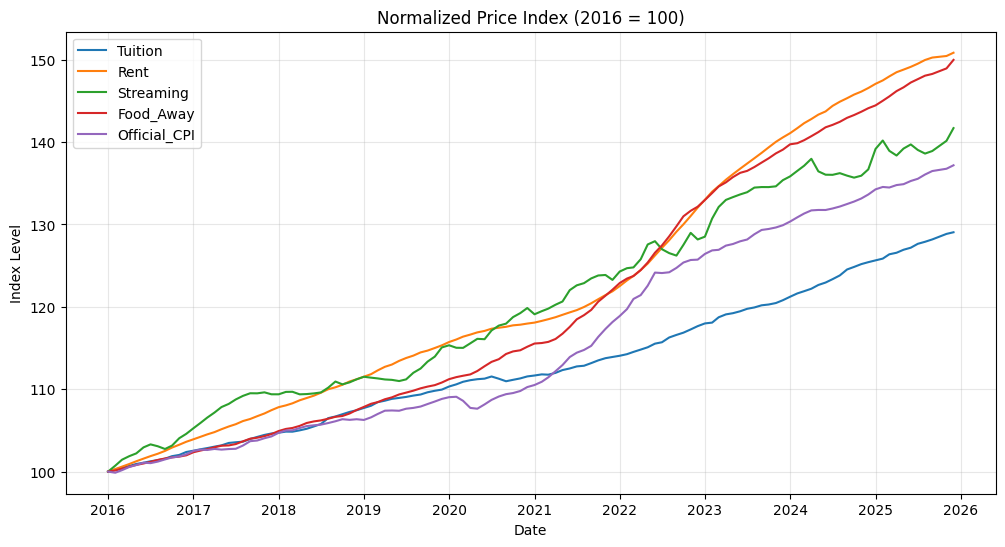

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for col in ["Tuition", "Rent", "Streaming", "Food_Away", "Official_CPI"]:
    plt.plot(df_norm.index, df_norm[col], label=col)

plt.title("Normalized Price Index (2016 = 100)")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


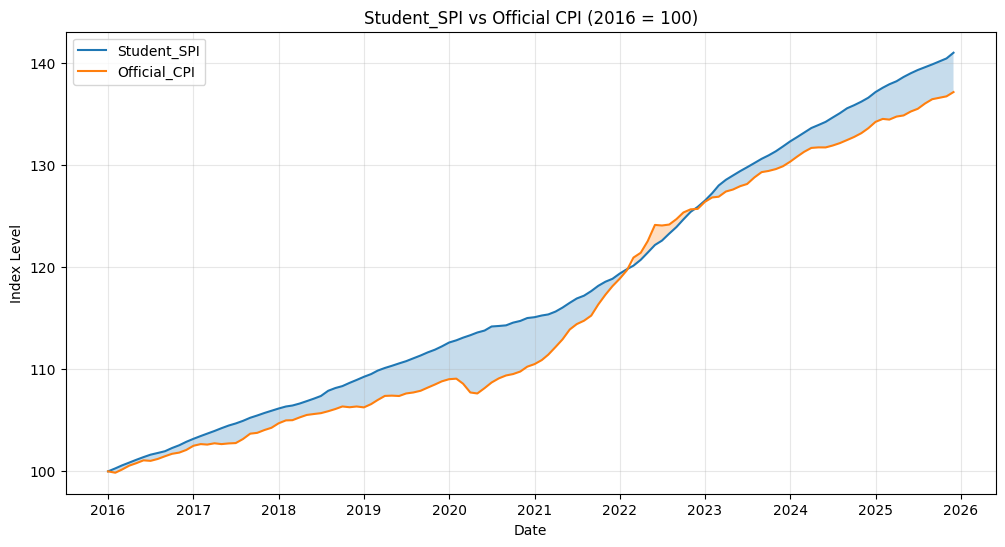

In [6]:
weights = {
    "Tuition": 0.40,
    "Rent": 0.30,
    "Food_Away": 0.20,
    "Streaming": 0.10,
}

df_norm["Student_SPI"] = sum(df_norm[k] * w for k, w in weights.items())

plt.figure(figsize=(12,6))
plt.plot(df_norm.index, df_norm["Student_SPI"], label="Student_SPI")
plt.plot(df_norm.index, df_norm["Official_CPI"], label="Official_CPI")

gap = df_norm["Student_SPI"] - df_norm["Official_CPI"]
plt.fill_between(df_norm.index, df_norm["Official_CPI"], df_norm["Student_SPI"], where=(gap>=0), alpha=0.25)
plt.fill_between(df_norm.index, df_norm["Official_CPI"], df_norm["Student_SPI"], where=(gap<0),  alpha=0.25)

plt.title("Student_SPI vs Official CPI (2016 = 100)")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


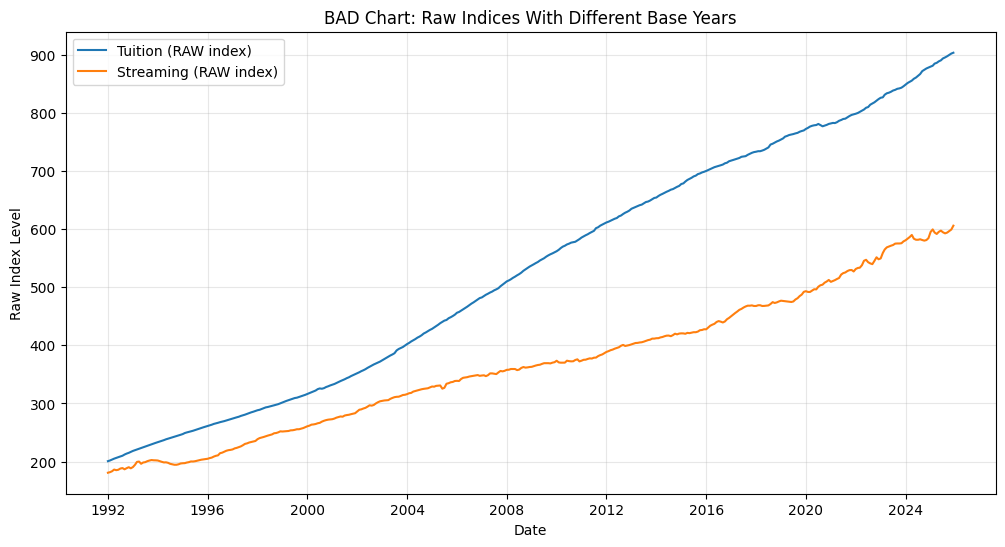

In [7]:
plt.figure(figsize=(12,6))
plt.plot(df_raw.index, df_raw["Tuition"], label="Tuition (RAW index)")
plt.plot(df_raw.index, df_raw["Streaming"], label="Streaming (RAW index)")

plt.title("BAD Chart: Raw Indices With Different Base Years")
plt.xlabel("Date")
plt.ylabel("Raw Index Level")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Index(['Official_CPI', 'Tuition', 'Rent', 'Streaming', 'Food_Away',
       'Student_SPI'],
      dtype='object')


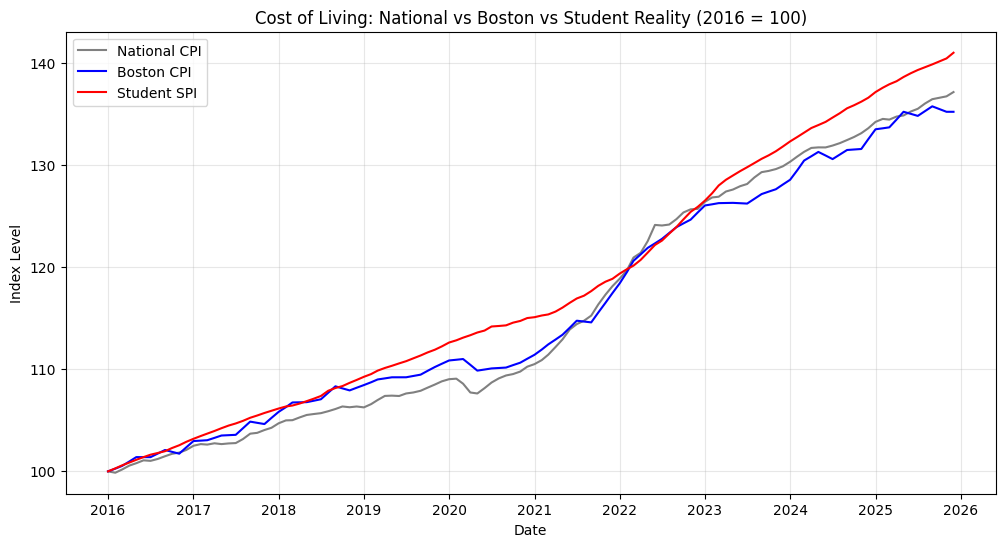

In [15]:
from fredapi import Fred
import matplotlib.pyplot as plt
import pandas as pd

fred = Fred(api_key="8b1e6eeda6b36c286470dfa0610028d9")

df = df_norm.copy()
print(df.columns)

boston_cpi = fred.get_series("CUURA103SA0")
boston_cpi.index = pd.to_datetime(boston_cpi.index)

boston_cpi = boston_cpi.reindex(df.index).interpolate(limit_direction="both")

base_date = df.index[df.index >= "2016-01-01"][0]
df["Boston_CPI"] = (boston_cpi / boston_cpi.loc[base_date]) * 100

plt.figure(figsize=(12,6))
plt.plot(df.index, df["Official_CPI"], color="grey", label="National CPI")
plt.plot(df.index, df["Boston_CPI"], color="blue", label="Boston CPI")
plt.plot(df.index, df["Student_SPI"], color="red", label="Student SPI")
plt.title("Cost of Living: National vs Boston vs Student Reality (2016 = 100)")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
